<a href="https://colab.research.google.com/github/kero2no1/data_analytics/blob/working/Data_analytics_outcome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ▼性格診断の回答から性別の特定は可能か？
---


性別と性格には関係性はないように思える。<br>
しかし、"男らしい性格"や"女らしい性格"という言葉が存在することから、<br>
もしかしたら、なんらかの関係性を持つのかもしれない。<br>
<br>
今回は、ビッグファイブ診断の回答結果から、<br>
性別を特定可能かどうかを検証してみることにする。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# データセットはタブ区切りなのでsepに\tを指定して読み込む
raw_df = pd.read_csv("/content/drive/MyDrive/dataset/BIG5/data.csv", sep="\t")
print(f"データ件数：{raw_df.shape[0]}／列数：{raw_df.shape[1]}")

データ件数：19719／列数：57


## データの確認と可視化
---
---


In [3]:
print(raw_df.dtypes)

race        int64
age         int64
engnat      int64
gender      int64
hand        int64
source      int64
country    object
E1          int64
E2          int64
E3          int64
E4          int64
E5          int64
E6          int64
E7          int64
E8          int64
E9          int64
E10         int64
N1          int64
N2          int64
N3          int64
N4          int64
N5          int64
N6          int64
N7          int64
N8          int64
N9          int64
N10         int64
A1          int64
A2          int64
A3          int64
A4          int64
A5          int64
A6          int64
A7          int64
A8          int64
A9          int64
A10         int64
C1          int64
C2          int64
C3          int64
C4          int64
C5          int64
C6          int64
C7          int64
C8          int64
C9          int64
C10         int64
O1          int64
O2          int64
O3          int64
O4          int64
O5          int64
O6          int64
O7          int64
O8          int64
O9        

*   country以外は数値データである
*   race  : 人種
*   age   : 年齢(13歳以上である)
*   engnat   : 母国語は英語か
*   gender  : 性別
*   hand   : 利き手
*   source   : オンライン診断にアクセスした手段
*   country   : オンライン診断にアクセスした国(ISOコード)
*   E1～O10はリッカート尺度(1:Disagree, 3:Neutral, 5:Agree)の診断項目

In [4]:
print(raw_df.describe(exclude="number"))
print("countryの欠損",raw_df["country"].isnull().sum(),"件")

       country
count    19710
unique     158
top         US
freq      8753
countryの欠損 9 件


*   国情報の欠損値は、人種情報から推測できるかもしれない。
*   種類が多い。文字列情報のため、数値化の必要あり。
>*  ひとまず使用しない方向で考える。(あとで加工して使う)


In [5]:
# 統計量の確認と入力ミスの確認
lists = ["race","age","engnat","gender","hand","source"]
print(raw_df[lists].describe())
print()
for col in lists:
  print(col,"入力ミス",(raw_df[col]==0).sum(),"件")

               race           age        engnat        gender          hand  \
count  19719.000000  1.971900e+04  19719.000000  19719.000000  19719.000000   
mean       5.324205  5.076703e+04      1.365130      1.616918      1.130128   
std        4.019064  7.121272e+06      0.488796      0.499122      0.413663   
min        0.000000  1.300000e+01      0.000000      0.000000      0.000000   
25%        3.000000  1.800000e+01      1.000000      1.000000      1.000000   
50%        3.000000  2.200000e+01      1.000000      2.000000      1.000000   
75%        8.000000  3.100000e+01      2.000000      2.000000      1.000000   
max       13.000000  1.000000e+09      2.000000      3.000000      3.000000   

            source  
count  19719.00000  
mean       1.95228  
std        1.50477  
min        1.00000  
25%        1.00000  
50%        1.00000  
75%        2.00000  
max        5.00000  

race 入力ミス 153 件
age 入力ミス 0 件
engnat 入力ミス 70 件
gender 入力ミス 24 件
hand 入力ミス 100 件
source 入力ミス 0 件



*   ageに異常な値が存在している(max=1*10^9)


<Axes: xlabel='gender', ylabel='count'>

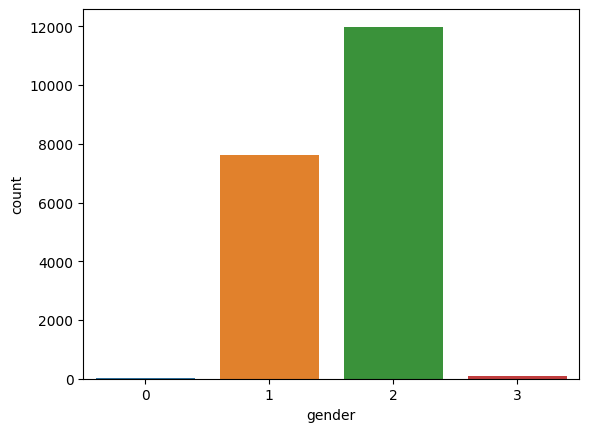

In [6]:
import seaborn as sns
sns.countplot(x="gender", data=raw_df)



*   データの男女比は 1:1.5
*   入力ミス(=0)とその他(=3)が含まれている


>*   入力ミスとその他を回答したデータは取り除いた方がよさそう。







In [7]:
cnt = raw_df[(raw_df["gender"] == 0) | (raw_df["gender"] == 3)]["gender"].sum()
print(f"削除対象データ数：{cnt}")

削除対象データ数：306


<Axes: xlabel='race', ylabel='count'>

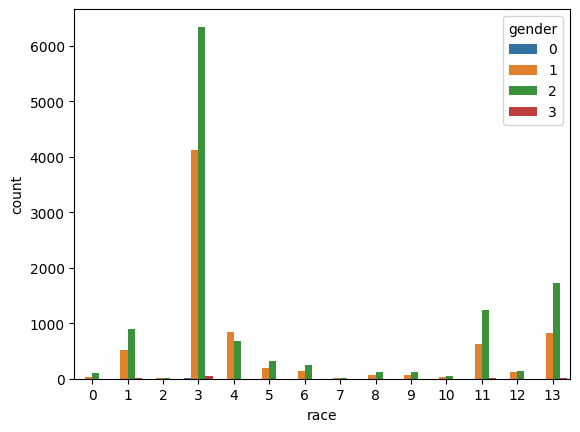

In [8]:
sns.countplot(x="race", hue="gender", data=raw_df)



*   どのカテゴリも男女比は概ね同じ
*   4=Caucasian (Indian) だけ逆転している
*   カテゴリーが多い、これもいったん予測に使わない方向で進める



<Axes: xlabel='engnat', ylabel='count'>

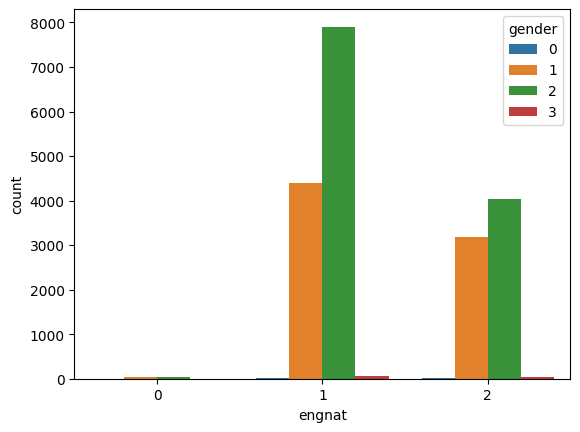

In [9]:
sns.countplot(x="engnat", hue="gender", data=raw_df)



*   入力ミス(=0)は削除する



<Axes: xlabel='hand', ylabel='count'>

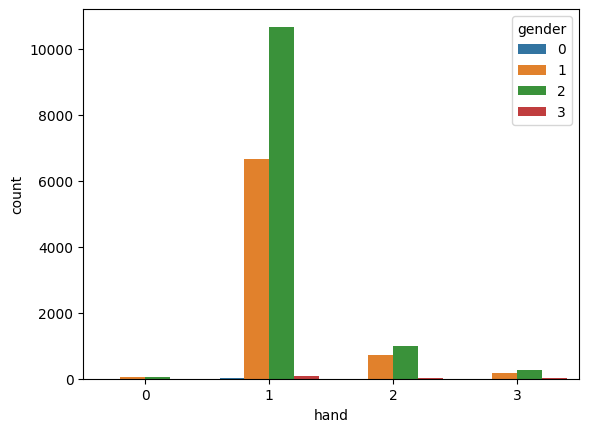

In [10]:
sns.countplot(x="hand", hue="gender",data=raw_df)



*   利き手はほぼ右利き、予測への影響は小さいかもしれない
*   入力ミス(=0)は削除する


<Axes: xlabel='source', ylabel='count'>

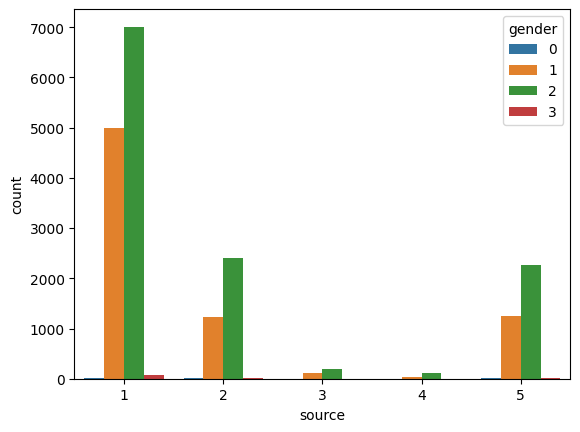

In [11]:
sns.countplot(x="source", hue="gender",data=raw_df)



*   アクセス手段と性格への因果関係は考えにくい
>*   予測には使わない(削除する)



count    19636.000000
mean        26.263801
std         11.567487
min         13.000000
25%         18.000000
50%         22.000000
75%         31.000000
max        100.000000
Name: age, dtype: float64



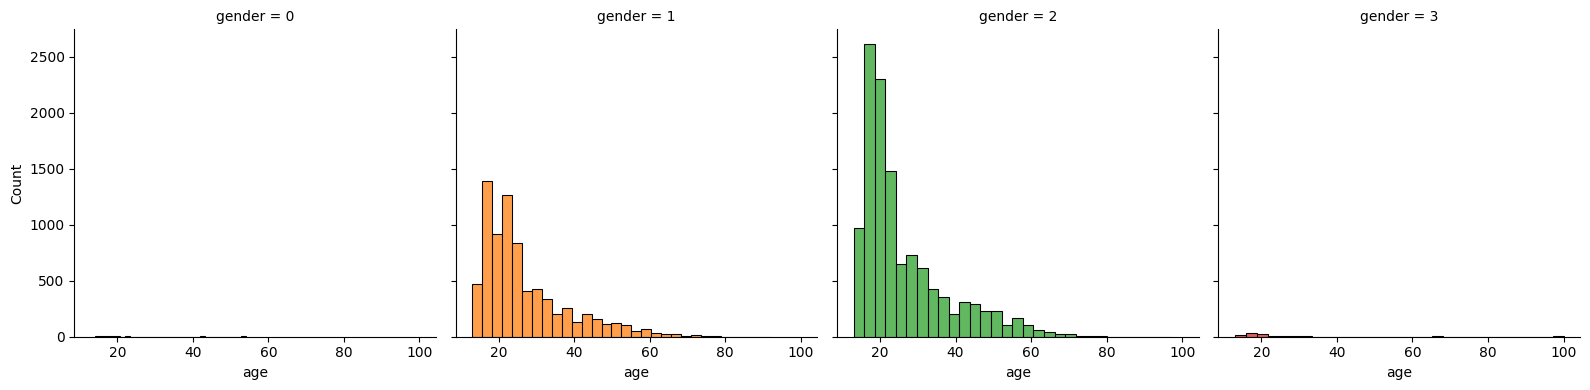

In [12]:
# ageについて可視化
# ひとまず100歳以下のみのデータの分布を確認
age_df = raw_df[raw_df["age"]<=100]
print(age_df["age"].describe())   # 統計量の再確認
print()
fig = sns.FacetGrid(age_df, col="gender", hue="gender", height=4)
fig.map(sns.histplot, "age", bins=30, kde=False)



*   回答者のほとんどは20代
*   80歳より大きい回答はほぼないため、80より大きい回答は平均値に置き換える




In [13]:
# 診断項目(回答は1～5で、0はミス)
# 0があるかチェック
for cat in ["E","N","A","C","O"]:
  col_list = [cat+str(idx) for idx in range(1,11)]
  for col in col_list:
    print(col, (raw_df[col] == 0).sum())

E1 1
E2 1
E3 1
E4 1
E5 1
E6 1
E7 1
E8 1
E9 1
E10 1
N1 1
N2 1
N3 1
N4 1
N5 1
N6 1
N7 1
N8 1
N9 1
N10 1
A1 1
A2 1
A3 1
A4 1
A5 1
A6 1
A7 1
A8 1
A9 1
A10 1
C1 1
C2 1
C3 1
C4 1
C5 1
C6 1
C7 1
C8 1
C9 1
C10 1
O1 1
O2 1
O3 1
O4 1
O5 1
O6 1
O7 1
O8 1
O9 1
O10 1


In [14]:
print(raw_df[raw_df["E1"] == 0])

       race  age  engnat  gender  hand  source country  E1  E2  E3  ...  O1  \
19064    13   52       2       2     1       2      IN   0   0   0  ...   0   

       O2  O3  O4  O5  O6  O7  O8  O9  O10  
19064   0   0   0   0   0   0   0   0    0  

[1 rows x 57 columns]




* 正しく回答されていないレコードが1件だけ存在する。
* このレコードは削除することにする。



In [15]:
likert_df = raw_df.drop(index=19064)
print(f"データ件数：{likert_df.shape[0]}／列数：{raw_df.shape[1]}")

データ件数：19718／列数：57


In [16]:
# 診断項目(1～5)の統計量
for cat in ["E","N","A","C","O"]:
  col_list = [cat+str(idx) for idx in range(1,11)]
  print(likert_df[col_list].describe())

                 E1            E2            E3            E4            E5  \
count  19718.000000  19718.000000  19718.000000  19718.000000  19718.000000   
mean       2.629070      2.759864      3.416929      3.152196      3.432397   
std        1.232454      1.313704      1.236612      1.222647      1.281803   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%        2.000000      2.000000      3.000000      2.000000      2.000000   
50%        3.000000      3.000000      4.000000      3.000000      4.000000   
75%        4.000000      4.000000      4.000000      4.000000      5.000000   
max        5.000000      5.000000      5.000000      5.000000      5.000000   

                 E6            E7            E8            E9           E10  
count  19718.000000  19718.000000  19718.000000  19718.000000  19718.000000  
mean       2.452734      2.867431      3.376661      3.094431      3.585506  
std        1.241524      1.431704      1.266200      1

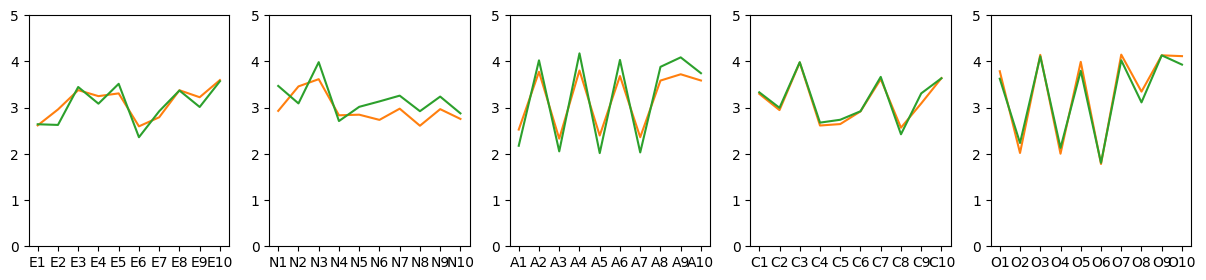

In [17]:
# 診断項目
fig = plt.figure(figsize=(15,3))
for idx, cat in enumerate(["E","N","A","C","O"]):
  col_list = [cat+str(idx) for idx in range(1,11)]
  ax = fig.add_subplot(1,5,idx+1)
  x = [label for label in col_list]
  y1 = [(likert_df[likert_df["gender"]==1][label]).mean() for label in col_list]
  y2 = [(likert_df[likert_df["gender"]==2][label]).mean() for label in col_list]
  ax.plot(x, y1, color="tab:orange")
  ax.plot(x, y2, color="tab:green")
  ax.set_ylim(0,5)
plt.show()



*   診断項目別に平均値を比較すると、全体的に大きな差はないように見える
>*  性別予測への影響はどうなるか






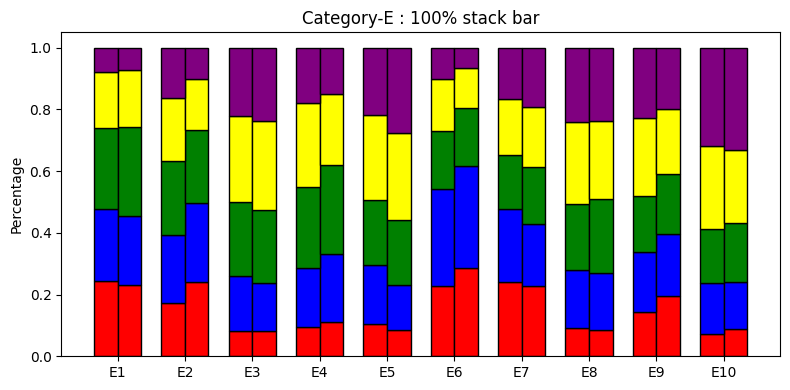

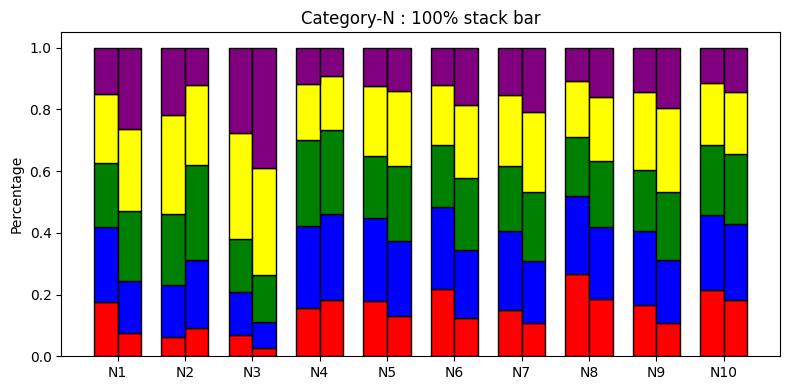

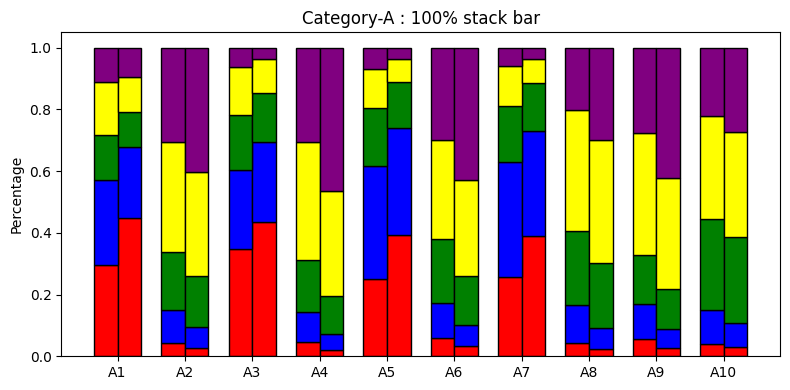

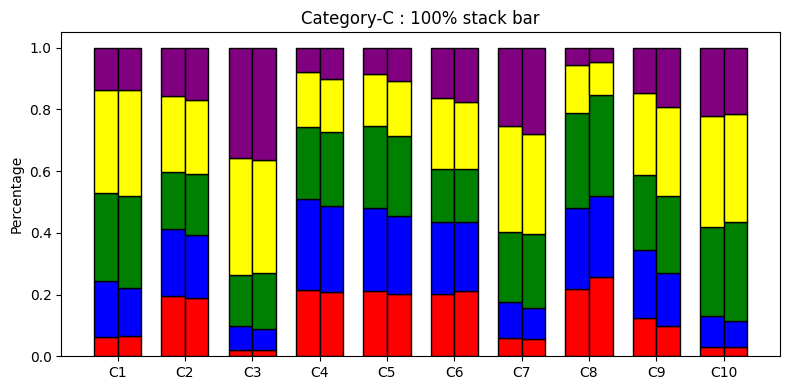

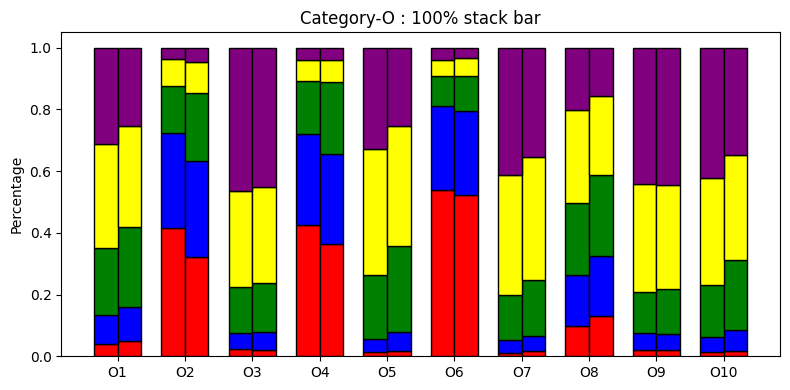

In [18]:
# 性別毎の回答の度数分布表(母数が異なるので100%積み上げ棒グラフ)
for cat in ["E","N","A","C","O"]:
  col_lists = [cat+str(idx) for idx in range(1,11)]
  col_lists.append("gender")

  # 診断項目と性別だけでを出して、性別でグループ化
  grp_df = likert_df[col_lists].groupby("gender")

  # 各回答毎(１～５)に集計
  male_cnts = grp_df.get_group(1).drop("gender", axis=1).apply(lambda x: x.value_counts()).fillna(0).transpose()
  female_cnts = grp_df.get_group(2).drop("gender", axis=1).apply(lambda x: x.value_counts()).fillna(0).transpose()

  # 100%積み上げのための処理
  male_cnts = male_cnts.div(male_cnts.sum(axis=1), axis=0)
  female_cnts = female_cnts.div(female_cnts.sum(axis=1), axis=0)

  # カテゴリごとにグラフ描画
  col_lists.remove("gender")
  width = 0.35
  ind = np.arange(len(male_cnts))
  colors = ["red", "blue", "green", "yellow", "purple"]

  fig, ax = plt.subplots(figsize=(8,4))
  for pv, value in enumerate(male_cnts.columns):
    ax.bar(ind - width/2, male_cnts[value], width, color=colors[pv], bottom=male_cnts.iloc[:, :pv].sum(axis=1), edgecolor="black")
    ax.bar(ind + width/2, female_cnts[value], width, color=colors[pv], bottom=female_cnts.iloc[:, :pv].sum(axis=1), edgecolor="black")

  ax.set_ylabel("Percentage")
  ax.set_title(f"Category-{cat} : 100% stack bar")
  ax.set_xticks(ind)
  ax.set_xticklabels(male_cnts.index)
  plt.tight_layout()
  plt.show()



*   左側が男性、右側が女性
*   各カテゴリで、ところどころに特徴があるように見える
>*  平均値比較で差分があるところと同じ



## データの前処理、検証データ作成
---
---



データの確認と可視化で得られた知見から、データの前処理を行う。
*   country：いったん削除
*   race：いったん削除
*   gender：入力ミス(=0)とその他(=3)は削除
*   engnat：入力ミス(=0)は削除
*   hand：入力ミス(=0)は削除
*   source：削除
*   age：80より大きい回答は平均値に置き換える
*   E1～O10：入力ミスは削除する



(19719, 57)
(19719, 54)
(19593, 54)
(19432, 54)
(19431, 54)
33.18830734393495
26
       age  engnat  gender  hand  E1  E2  E3  E4  E5  E6  ...  O1  O2  O3  O4  \
19426   15       1       2     1   1   4   3   5   4   3  ...   1   3   5   3   
19427   37       1       2     1   2   3   2   3   2   3  ...   1   2   3   2   
19428   16       2       1     1   2   5   4   5   5   5  ...   5   3   1   3   
19429   16       1       1     1   1   4   2   3   2   4  ...   3   2   5   3   
19430   35       1       1     1   2   3   1   5   3   3  ...   5   1   5   1   

       O5  O6  O7  O8  O9  O10  
19426   4   1   4   2   5    3  
19427   3   3   4   2   3    3  
19428   4   1   1   5   5    5  
19429   4   1   5   3   5    5  
19430   4   1   5   5   5    5  

[5 rows x 54 columns]
(19431, 54)
count    19431.000000
mean        26.235088
std         11.473508
min         13.000000
25%         18.000000
50%         22.000000
75%         31.000000
max         80.000000
Name: age, dtype: float

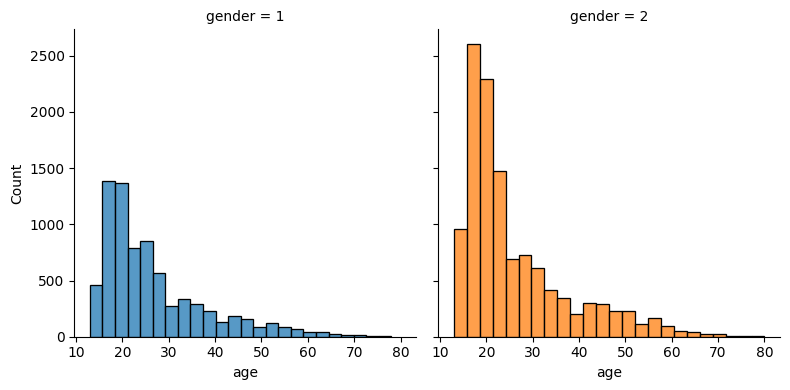

In [30]:
print(raw_df.shape)

# country, race, sourceの加工
del_columns = ["country","race","source"]
df = raw_df.drop(del_columns, axis=1)
print(df.shape)

# genderの加工
df = df[(df["gender"] != 0) & (df["gender"] != 3)]
print(df.shape)

# engnat,handの加工
df = df[df["engnat"] != 0]
df = df[df["hand"] != 0]
print(df.shape)

# 診断項目の加工
df = df[df["E1"] != 0]
print(df.shape)

# ageの加工
# 80以下の情報で平均値を算出
mean = df["age"].mean()
print(mean)
mean = int(df[df["age"] <= 80]["age"].mean())
print(mean)
df['age'].where(df["age"] <= 80, mean, inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.tail())
print(df.shape)

# 年齢分布の再確認
print(df["age"].describe())   # 統計量の再確認
print()
# ～100でbins=30だったので、～80ではbins=24にして調整
fig = sns.FacetGrid(df, col="gender", hue="gender", height=4)
fig.map(sns.histplot, "age", bins=24, kde=False)

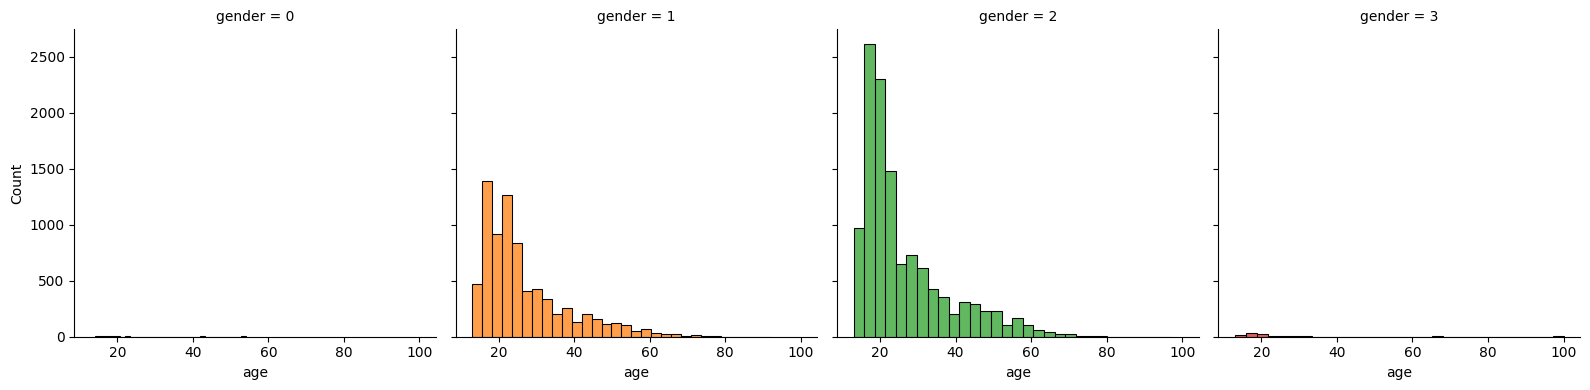

In [20]:
# 再掲(binsの差があるので、大きな影響はないと判断)
age_df = raw_df[raw_df["age"]<=100]
fig = sns.FacetGrid(age_df, col="gender", hue="gender", height=4)
fig.map(sns.histplot, "age", bins=30, kde=False)

## モデルの作成と予測
---
---

In [21]:
from sklearn.model_selection import train_test_split

# 前処理を施したdfを訓練データとテストデータに分割
train = df.drop("gender",axis=1)
target = df["gender"]

# 訓練データの一部を分割し検証データを作成(検証データは2割)
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=0.2, shuffle=True, random_state=8)

### いろいろな分類器を試してみる

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score

# モデルを定義
classifiers = {
    "ロジスティック回帰":LogisticRegression(max_iter=300),  # デフォルト100だとWarning
    "K近傍法":KNeighborsClassifier(),
    "サポートベクターマシン(Linear)":SVC(kernel="linear",random_state=8),
    "サポートベクターマシン(RBF)":SVC(kernel="rbf",random_state=8),
    "ランダムフォレスト":RandomForestClassifier(random_state=8),
    "AdaBoost":AdaBoostClassifier(random_state=8)
}

for key in classifiers.keys():
  # 学習
  classifiers[key].fit(X_train, y_train)

  # 訓練データと検証データに対しての予測を行う
  y_pred = classifiers[key].predict(X_train)
  y_val_pred = classifiers[key].predict(X_val)

  # 正答率を比較
  print(f"訓練={accuracy_score(y_train, y_pred)} ／ 検証={accuracy_score(y_val, y_val_pred)} : {key}")


訓練=0.6893978383942357 ／ 検証=0.6742989452019552 : ロジスティック回帰
訓練=0.7628023674729799 ／ 検証=0.6369951119114998 : K近傍法
訓練=0.6893978383942357 ／ 検証=0.6758425520967327 : サポートベクターマシン(Linear)
訓練=0.7067678847143593 ／ 検証=0.6876768716233599 : サポートベクターマシン(RBF)
訓練=1.0 ／ 検証=0.6827887831232313 : ランダムフォレスト
訓練=0.6898481729284611 ／ 検証=0.6773861589915101 : AdaBoost


### 予測精度向上にあたっての試行錯誤

In [23]:
# オーバーサンプリングとアンダーサンプリングを試してみる
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

female_cnt_train = y_train.value_counts()[2]
ros = RandomOverSampler(sampling_strategy={1:np.round(female_cnt_train/1.25).astype(int), 2:female_cnt_train}, random_state=8)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train)

male_cnt_train = y_train.value_counts()[1]
rus = RandomUnderSampler(sampling_strategy={1:male_cnt_train, 2:np.round(male_cnt_train*1.25).astype(int)}, random_state=8)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

# print(y_train_os.value_counts()[1],y_train_os.value_counts()[2],y_train_us.value_counts()[1],y_train_us.value_counts()[2])
# print()

print("<<オーバーサンプリング後>>")
for key in classifiers.keys():
  # 学習
  classifiers[key].fit(X_train_os, y_train_os)

  # 訓練データと検証データに対しての予測を行う
  y_pred = classifiers[key].predict(X_train_os)
  y_val_pred = classifiers[key].predict(X_val)

  # 正答率を比較
  print(f"訓練={accuracy_score(y_train_os, y_pred)} ／ 検証={accuracy_score(y_val, y_val_pred)} : {key}")

print("<<アンダーサンプリング後>>")
for key in classifiers.keys():
  # 学習
  classifiers[key].fit(X_train_us, y_train_us)

  # 訓練データと検証データに対しての予測を行う
  y_pred = classifiers[key].predict(X_train_us)
  y_val_pred = classifiers[key].predict(X_val)

  # 正答率を比較
  print(f"訓練={accuracy_score(y_train_us, y_pred)} ／ 検証={accuracy_score(y_val, y_val_pred)} : {key}")


<<オーバーサンプリング後>>
訓練=0.6746240711485577 ／ 検証=0.6696681245176228 : ロジスティック回帰
訓練=0.7709320695102686 ／ 検証=0.6256753280164652 : K近傍法
訓練=0.6746825814756304 ／ 検証=0.6670954463596604 : サポートベクターマシン(Linear)
訓練=0.6975601193610672 ／ 検証=0.6959094417288397 : サポートベクターマシン(RBF)
訓練=1.0 ／ 検証=0.6789297658862876 : ランダムフォレスト
訓練=0.6769644842314668 ／ 検証=0.6755852842809364 : AdaBoost
<<アンダーサンプリング後>>
訓練=0.6711241734019103 ／ 検証=0.6688963210702341 : ロジスティック回帰
訓練=0.750991917707568 ／ 検証=0.6246462567532801 : K近傍法
訓練=0.672226304188097 ／ 検証=0.6688963210702341 : サポートベクターマシン(Linear)
訓練=0.6939015429831007 ／ 検証=0.695137638281451 : サポートベクターマシン(RBF)
訓練=1.0 ／ 検証=0.6753280164651402 : ランダムフォレスト
訓練=0.6753857457751653 ／ 検証=0.6696681245176228 : AdaBoost




*   サポートベクタマシン(RBF)での予測精度が一番よい
*   25%のオーバーサンプリング/アンダーサンプリングでやや精度向上が見られる



In [24]:
# 相関行列(特徴量が多いので、件数のみチェック)
df_corr = df.corr()

print(df_corr[(df_corr >= 0.7) & (df_corr != 1)].count())
print(df_corr[(df_corr >= 0.4) & (df_corr != 1)].count())
print(df_corr[(df_corr <= -0.7) & (df_corr != 1)].count())
print(df_corr[(df_corr <= -0.4) & (df_corr != 1)].count())

age       0
engnat    0
gender    0
hand      0
E1        0
E2        0
E3        0
E4        0
E5        0
E6        0
E7        0
E8        0
E9        0
E10       0
N1        0
N2        0
N3        0
N4        0
N5        0
N6        0
N7        1
N8        1
N9        0
N10       0
A1        0
A2        0
A3        0
A4        0
A5        0
A6        0
A7        0
A8        0
A9        0
A10       0
C1        0
C2        0
C3        0
C4        0
C5        0
C6        0
C7        0
C8        0
C9        0
C10       0
O1        0
O2        0
O3        0
O4        0
O5        0
O6        0
O7        0
O8        0
O9        0
O10       0
dtype: int64
age       0
engnat    0
gender    0
hand      0
E1        4
E2        3
E3        5
E4        4
E5        4
E6        3
E7        4
E8        1
E9        4
E10       3
N1        6
N2        0
N3        2
N4        0
N5        2
N6        7
N7        5
N8        5
N9        6
N10       5
A1        0
A2        1
A3        0
A4        3
A5 



*   0.7以上の強い正の相関は1か所だけ(N7とN8)
*   0.4以上の弱い正の相関、負の相関はいくつか見られる
>*  主成分分析などで次元削減すると効果あるか？



In [25]:
# 主成分分析を用いた次元削減
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(train)
X_scaled=scaler.transform(train)

pca=PCA(n_components=0.95)  # 95%の寄与率になるまで削減する
pca.fit(X_scaled)

train_pca=pca.transform(X_scaled)
print(train_pca.shape)

# 訓練データの一部を分割し検証データを作成(検証データは2割)
X_train, X_val, y_train, y_val = train_test_split(train_pca, target, test_size=0.2, shuffle=True, random_state=8)

for key in classifiers.keys():
  # 学習
  classifiers[key].fit(X_train, y_train)

  # 訓練データと検証データに対しての予測を行う
  y_pred = classifiers[key].predict(X_train)
  y_val_pred = classifiers[key].predict(X_val)

  # 正答率を比較
  print(f"訓練={accuracy_score(y_train, y_pred)} ／ 検証={accuracy_score(y_val, y_val_pred)} : {key}")

(19431, 45)
訓練=0.6883041688111168 ／ 検証=0.6722408026755853 : ロジスティック回帰
訓練=0.7563690169840452 ／ 検証=0.6354515050167224 : K近傍法
訓練=0.6910705095213587 ／ 検証=0.673012606122974 : サポートベクターマシン(Linear)
訓練=0.7951621204323212 ／ 検証=0.6827887831232313 : サポートベクターマシン(RBF)
訓練=1.0 ／ 検証=0.6637509647543093 : ランダムフォレスト
訓練=0.6917138445702522 ／ 検証=0.6647800360174942 : AdaBoost




*   主成分分析では精度向上は見られなかった



In [40]:
# カテゴリカル変数への変換
df_catg = df.copy()
df_catg["ageBand"] = pd.qcut(df_catg["age"], 4)
df_catg = pd.get_dummies(df_catg, columns=["ageBand","engnat","hand"])
df_catg = df_catg.drop("age", axis=1)
print(df_catg.columns)

Index(['gender', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10',
       'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'A1', 'A2',
       'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6',
       'O7', 'O8', 'O9', 'O10', 'ageBand_(12.999, 18.0]',
       'ageBand_(18.0, 22.0]', 'ageBand_(22.0, 31.0]', 'ageBand_(31.0, 80.0]',
       'engnat_1', 'engnat_2', 'hand_1', 'hand_2', 'hand_3'],
      dtype='object')


In [51]:
# 前処理を施したdfを訓練データとテストデータに分割
train = df_catg.drop("gender",axis=1)
target = df_catg["gender"]

# 訓練データの一部を分割し検証データを作成(検証データは2割)
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=0.2, shuffle=True, random_state=8)

# オーバーサンプリング
female_cnt_train = y_train.value_counts()[2]
ros = RandomOverSampler(sampling_strategy={1:np.round(female_cnt_train/1.25).astype(int), 2:female_cnt_train}, random_state=8)
X_train, y_train = ros.fit_resample(X_train, y_train)

# # アンダーサンプリング
# male_cnt_train = y_train.value_counts()[1]
# rus = RandomUnderSampler(sampling_strategy={1:male_cnt_train, 2:np.round(male_cnt_train*1.25).astype(int)}, random_state=8)
# X_train, y_train = rus.fit_resample(X_train, y_train)

for key in classifiers.keys():
  # 学習
  classifiers[key].fit(X_train, y_train)

  # 訓練データと検証データに対しての予測を行う
  y_pred = classifiers[key].predict(X_train)
  y_val_pred = classifiers[key].predict(X_val)

  # 正答率を比較
  print(f"訓練={accuracy_score(y_train, y_pred)} ／ 検証={accuracy_score(y_val, y_val_pred)} : {key}")


訓練=0.6747410918027031 ／ 検証=0.6776434268073064 : ロジスティック回帰
訓練=0.7680065531566321 ／ 検証=0.6300488808850013 : K近傍法
訓練=0.6779006494646305 ／ 検証=0.6781579624388989 : サポートベクターマシン(Linear)
訓練=0.7402726581241589 ／ 検証=0.6861332647285825 : サポートベクターマシン(RBF)
訓練=0.9998829793458546 ／ 検証=0.6820169796758425 : ランダムフォレスト
訓練=0.6757357673629396 ／ 検証=0.6758425520967327 : AdaBoost




*   カテゴリカル変数の変換による精度向上はみられなかった



In [56]:
# ageだけ変換してはどうか？
df_Band = df.copy()
df_Band["ageBand"] = pd.qcut(df_Band["age"], 4)
df_Band = pd.get_dummies(df_Band, columns=["ageBand"])
df_Band = df_Band.drop("age", axis=1)

# 前処理を施したdfを訓練データとテストデータに分割
train = df_Band.drop("gender",axis=1)
target = df_Band["gender"]

# 主成分分析による次元削減
scaler=StandardScaler()
scaler.fit(train)
X_scaled=scaler.transform(train)

pca=PCA(n_components=0.95)  # 95%の寄与率になるまで削減する
pca.fit(X_scaled)

train=pca.transform(X_scaled)

# 訓練データの一部を分割し検証データを作成(検証データは2割)
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=0.2, shuffle=True, random_state=8)

# オーバーサンプリング
female_cnt_train = y_train.value_counts()[2]
ros = RandomOverSampler(sampling_strategy={1:np.round(female_cnt_train/1.25).astype(int), 2:female_cnt_train}, random_state=8)
X_train, y_train = ros.fit_resample(X_train, y_train)

# # アンダーサンプリング
# male_cnt_train = y_train.value_counts()[1]
# rus = RandomUnderSampler(sampling_strategy={1:male_cnt_train, 2:np.round(male_cnt_train*1.25).astype(int)}, random_state=8)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# サポートベクタマシン(RBF)だけ
model = SVC(random_state=8, kernel="rbf")

# 学習
model.fit(X_train, y_train)

# 訓練データと検証データに対しての予測を行う
y_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# 正答率を比較
print(f"訓練={accuracy_score(y_train, y_pred)} ／ 検証={accuracy_score(y_val, y_val_pred)} : サポートベクタマシン(RBF)")


訓練=0.8094318647241238 ／ 検証=0.6933367635708773 : サポートベクタマシン(RBF)




*   いろいろ組み合わせても、これ以上は向上しない
>*  初期状態にオーバーサンプリングを施したSVM(RBF)が最大

